In [1]:
import glob
import logging
import os
import warnings
from itertools import repeat
from multiprocessing.pool import Pool
from pathlib import Path

import cartopy.crs as ccrs
import folium
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap
from shapely.geometry import Polygon
from sklearn.metrics import recall_score, roc_auc_score
from tqdm import tqdm

import G211
import nclcmaps
from lightning import get_obs, ztfs

%matplotlib inline
from ml_functions import (
    brier_skill_score,
    configs_match,
    get_argparser,
    get_features,
    load_df,
    predct,
    rptdist2bool,
)
from spc import (
    convective_outlook_colors,
    enhtstm_colors,
    get_issuance_time,
    get_outlooks,
)
from statisticplot import make_map, stat_plots

sns.set_theme()

logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)

2023-10-31 09:30:34.527532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 09:30:34.826786: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# color map for SPC outlook
convective_outlook_colors
# color map for SPC enhanced tstm outlook
enhtstm_cmap = ListedColormap(list(enhtstm_colors.values()), name="tstm outlook")

test = nclcmaps.colors["MPL_Greys"][10:-10:] + nclcmaps.colors["MPL_Reds"]
cmap = ListedColormap(test, "GreysReds")
norm = BoundaryNorm(np.arange(0, 21, 1), ncolors=cmap.N, clip=True)

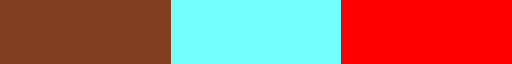

In [3]:
enhtstm_cmap

In [4]:
# map projection
map_crs = G211.g211
grid = G211.grid
conus_mask = G211.mask

In [5]:
def shp2ds(gs, issue, valid_start_hour, valid_end_hour):
    """
    convert geopandas dataframe to xarray dataset
    """
    df = conus_mask.to_dataframe(name="conus").join(
        gs.drop(columns="geometry").sort_index()
    )
    da = []
    for c in df.columns:
        da.append(xarray.DataArray(df[c].unstack("x").values, name=c, dims=["y", "x"]))
    ds = xarray.merge(da)
    ds["issue"] = issue
    ds["valid_start_hour"] = valid_start_hour
    ds["valid_end_hour"] = valid_end_hour
    return ds

### Load SPC enhanced tstm outlook

In [6]:
# downloaded by get_enhtstm.ipynb
tmpdir = Path(os.getenv("TMPDIR"))
sfiles = (tmpdir / "enhtstm").glob("????/*.zip")
sfiles = sorted(sfiles)
bad_file = (
    tmpdir / "enhtstm/2020/enh12_20200215_150400_202002150222-shp.zip"
)  # incomplete
assert bad_file not in sfiles

for ifile in tqdm(sfiles):
    ofile = ifile.with_suffix(".nc")
    if os.path.exists(ofile):
        continue
    gs = geopandas.read_file(ifile)

    issue, valid_start, valid_end = get_issuance_time(ifile)

    gs = grid.to_crs(gs.crs).sjoin(gs, how="inner", rsuffix="poly")
    # convert shapes to grid
    ds = shp2ds(gs, issue, valid_start.hour, valid_end.hour)
    print(ofile)
    ds.to_netcdf(ofile)

100%|██████████| 15425/15425 [00:06<00:00, 2215.05it/s]


In [7]:
# SPC convective outlooks
convoutlook = False
if convoutlook:
    agdf = get_outlooks()
    agdf.head(170).tail()

    # examples of SPC issuances with a particular risk threshold
    risk = "ENH"
    ih = agdf["THRESHOLD"] == risk
    print(f"{sum(ih)} {risk} risk days")
    c = agdf.loc[ih].sort_values("PRODISS").PRODISS.values
    print(c[20::100])

In [18]:
m = tmpdir.glob("enhtstm/2021/enh00_20210722_222000_2021072*-shp.zip")
list(m)[1]

PosixPath('/glade/derecho/scratch/ahijevyc/tmp/enhtstm/2021/enh00_20210722_222000_202107221551-shp.zip')

In [21]:
ifile = sfiles[5098]
# ifile = sfiles[4853]
# ifile = tmpdir / "enhtstm/2021/enh20_20210721_211600_202107210450-shp.zip"
gs = geopandas.read_file(ifile)
issue, valid_start, valid_end = get_issuance_time(ifile)

# Assign value to grid points within polygons
gs = grid.to_crs(gs.crs).sjoin(gs, how="inner", rsuffix="poly")
gs["issue"] = issue
# convert to str avoids TypeError: Object of type Timestamp is not JSON serializable
gs["valid_start"] = valid_start.strftime("%Y%m%d %H:%M")
gs["valid_end"] = valid_end.strftime("%Y%m%d %H:%M")
issue, valid_start, valid_end

('1300',
 datetime.datetime(2021, 7, 22, 20, 0),
 datetime.datetime(2021, 7, 23, 0, 0))

In [22]:
if convoutlook:
    import requests

    # Choose a particular convective outlook, grab issue time and expire time
    prodiss = "201803261955"
    issue = pd.to_datetime(agdf[agdf.PRODISS.eq(prodiss)].ISSUE.iloc[0])
    expire = pd.to_datetime(agdf[agdf.PRODISS.eq(prodiss)].EXPIRE.iloc[0])

    if issue < pd.to_datetime("20221128"):
        column = "THRESHOLD"
        subset = agdf["DAY"].eq(1) & agdf["CATEGORY"].eq("CATEGORICAL")
        subset = subset & agdf["PRODISS"].eq(prodiss)
        gdf = agdf[subset]
    else:
        ifile = requests.get(
            "https://www.spc.noaa.gov/products/outlook/day1otlk_cat.nolyr.geojson"
        )
        gdf = geopandas.GeoDataFrame.from_features(ifile.json())
        gdf = gdf.set_crs("epsg:4269")
        column = "LABEL"
    gdf

    if False:
        # Subtract higher thresholds from lower thresholds so they don't overlap
        cat = "TSTM"
        for subtract in ["MRGL", "SLGT", "ENH", "MDT", "HIGH"]:
            logging.debug(f"subtracting {subtract}")
            gdf.loc[gdf[column].eq(cat)] = (
                gdf.loc[gdf[column].eq(cat)]
                .overlay(gdf[gdf[column].eq(subtract)], how="difference")
                .values
            )
            cat = subtract
            if subtract not in gdf[column]:
                break

## read lightning observations into xarray Datasets and convert either GLM Dataset (glmds) or Weatherbug dataset (cgds) to geopandas DataFrame (obsgdf)

In [23]:
def get_obsgdf(args, valid_start, valid_end, obsvar, rptdist):
    twin = args.twin
    f = f"{obsvar}_{rptdist}km_{twin}hr"
    df = load_df(args)
    df = df[df.valid_time == valid_start + pd.Timedelta(hours=twin / 2)]
    df = df[[f, "lon", "lat", "x", "y"]].rename(columns={f: obsvar})

    obsgdf = geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lon, df.lat)
    )
    obsgdf = obsgdf.set_crs(ccrs.PlateCarree())

    return obsgdf

In [24]:
spc_fcst = gs.to_crs(ccrs.PlateCarree())
column = "DN"
obsvar = "cg.ic"
o_thresh = 1
twin = 4
rptdist = 20

parser = get_argparser()
# use [0, 1, 2] time windows for ['sighail', 'sigwind', 'hailone', 'wind', 'torn'] until we update parquet files with [1,2,4]
rpttwin = int(
    np.floor(twin / 2)
)  # Ryan's original way of naming storm rpt time windows
args = parser.parse_args(
    args="--model HRRR --batchsize 1024 --neurons 1024 --optim SGD"
    " --trainstart 20191002 --trainend 20201202 "
    f"--flash {o_thresh} "
    f"--twin {twin} "
    f"--savedmodel nn/lightning/{o_thresh:02d}+.{twin}hr "
    f"--labels "
    # f"sighail_{rptdist}km_{rpttwin}hr sigwind_{rptdist}km_{rpttwin}hr "
    # f"hailone_{rptdist}km_{rpttwin}hr wind_{rptdist}km_{rpttwin}hr torn_{rptdist}km_{rpttwin}hr any_{rptdist}km_{rpttwin}hr "
    f"cg_20km_{twin}hr ic_20km_{twin}hr  cg.ic_20km_{twin}hr  flashes_20km_{twin}hr "
    f"cg_40km_{twin}hr ic_40km_{twin}hr  cg.ic_40km_{twin}hr  flashes_40km_{twin}hr "
    " --epochs 10 --learning 0.001 --kfold 1".split()
)
setattr(args, "idate", pd.to_datetime(valid_start).floor("1D"))
args

Namespace(batchnorm=False, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=10, labels=['cg_20km_4hr', 'ic_20km_4hr', 'cg.ic_20km_4hr', 'flashes_20km_4hr', 'cg_40km_4hr', 'ic_40km_4hr', 'cg.ic_40km_4hr', 'flashes_40km_4hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=Timestamp('2021-07-22 00:00:00'), ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='SGD', reg_penalty=0.01, savedmodel='nn/lightning/01+.4hr', seed=None, trainend=Timestamp('2020-12-02 00:00:00'), trainstart=Timestamp('2019-10-02 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), teststart=Timestamp('2020-12-02 12:00:00'), twin=4, suite='default')

In [25]:
obsgdf = get_obsgdf(args, valid_start, valid_end, obsvar, rptdist)

2023-10-31 09:35:13,396 Create /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.2021072200-0000.par from 1 HRRR files.
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
2023-10-31 09:35:20,781 Drop na
2023-10-31 09:35:20,797 kept 15696/62784 25% rows


In [26]:
import folium.plugins

m = folium.plugins.DualMap(location=[40, -95], zoom_start=3)
# 40-km rptdist
get_obsgdf(args, valid_start, valid_end, obsvar, 40).explore(
    m=m.m1, column=obsvar, name="40"
)
# 20-km rptdist
obsgdf.explore(m=m.m2, column=obsvar)

2023-10-31 09:35:26,972 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.2021072200-0000.par 0.1G mtime Tue Oct 31 09:35:20 2023 240 features 8 labels and 4 index_cols & dropna.


In [27]:
m = spc_fcst.explore(
    column=column,
    categories=spc_fcst[column].unique().tolist(),
    cmap=enhtstm_cmap,
    name="DN",
    marker_kwds=dict(radius=4),
)
obsgdf[obsgdf[obsvar] >= o_thresh].explore(
    m=m, marker_kwds=dict(color="yellow", fill=False), name=f"{obsvar} ≥ {o_thresh}"
)
folium.LayerControl().add_to(m)
m

In [28]:
# MOS LAMP lightning forecast
LAMP = False
if LAMP:
    from awips.dataaccess import DataAccessLayer

    DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
    request = DataAccessLayer.newDataRequest()
    request.setDatatype("grid")
    request.setLocationNames("LAMP2p5")
    request.setParameters("PROLGHT2hr")
    # request.setLevels("2.0FHAG")

    # Take a look at our request
    logging.info(request)

    grid_locations = DataAccessLayer.getAvailableLevels(request)
    grid_locations.sort()
    list(grid_locations)

    cycles = DataAccessLayer.getAvailableTimes(request, True)
    times = DataAccessLayer.getAvailableTimes(request)
    fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)

    # Get the most recent grid data
    response = DataAccessLayer.getGridData(request, [fcstRun[0]])

    logging.info(f"{len(times)} available times {len(fcstRun)} forecast runs")

    grid = response[0]
    data = grid.getRawData()
    lons, lats = grid.getLatLonCoords()
    bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

    data[data == -999999] = np.nan
    data.min()
    np.nanmin(data)

    fig, ax = make_map(bbox=bbox, projection=map_crs)
    cs = ax.pcolormesh(
        lons, lats, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree()
    )
    cbar = fig.colorbar(cs, shrink=0.7, orientation="horizontal")
    cbar.set_label(
        grid.getLocationName()
        + " "
        + grid.getLevel()
        + " "
        + grid.getParameter()
        + " ("
        + grid.getUnit()
        + ") "
        + "valid "
        + str(grid.getDataTime().getRefTime())
    )

    fig2, ax2 = make_map(bbox=bbox, projection=map_crs)
    cs2 = ax2.contour(
        lons,
        lats,
        data,
        80,
        cmap=cmap,
        levels=6,
        transform=ccrs.PlateCarree(),
        vmin=np.nanmin(data),
        vmax=np.nanmax(data),
    )
    cbar2 = fig2.colorbar(cs2, shrink=0.7, orientation="horizontal")
    cbar2.set_label(
        grid.getLocationName()
        + " "
        + grid.getLevel()
        + " "
        + grid.getParameter()
        + " ("
        + grid.getUnit()
        + ") "
        + "valid "
        + str(grid.getDataTime().getRefTime())
    )

## Define observation numpy array, geodataframe, thresholds

In [29]:
# simple 1-D numpy array of observations for verification
obs = obsgdf.set_index(["x", "y"])[obsvar]

# drop nans outside CONUS (mask applied earlier)
obs = obs[~np.isnan(obs)]

# truncate observation geodataframe based on event threshold (used for plots)
o = obsgdf[obsgdf[obsvar] >= o_thresh]

# Alternative event thresholds for observations (evenly spaced logrithmically)
thresh = np.round(np.logspace(0, 3, 16), decimals=0).astype(int)
thresh = pd.Series([o_thresh], name=f"{obsvar} threshold")

### Verify SPC enhanced tstm forecast

In [30]:
fcst = spc_fcst
# so we can apply 6045-element mask
fcst = fcst.merge(grid, on=["x", "y"], how="right")
fcst = fcst.DN / 100
# Drop values outside CONUS
fcst = fcst[conus_mask.data.ravel()]
# Assign 0 to points outside forecast polygons
fcst[np.isnan(fcst)] = 0
fcst.name = "SPC"

pthresh = pd.Series([10, 40, 70], name=f"fcst prob\nthresh") / 100.0

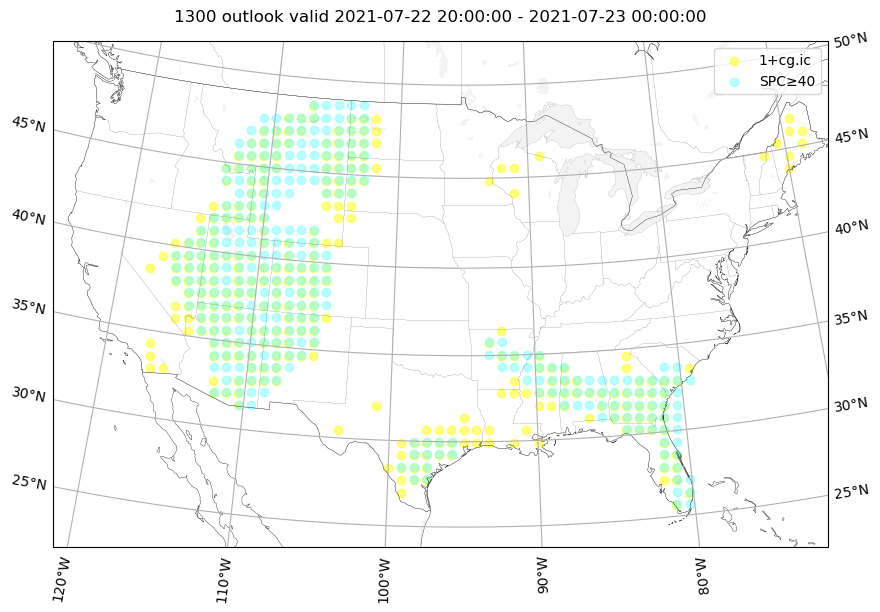

In [31]:
sns.reset_defaults()
fig, ax = make_map()
f_thresh = 40
assert f_thresh in [10, 40, 70]
ax.set_title(f"{issue} outlook valid {valid_start} - {valid_end}")
o.plot(
    color="yellow",
    alpha=0.5,
    ax=ax,
    transform=ccrs.PlateCarree(),
    label=f"{o_thresh}+{obsvar}",
)
spc_fcst[spc_fcst.DN >= f_thresh].plot(
    color=enhtstm_colors[f_thresh],
    alpha=0.5,
    ax=ax,
    transform=ccrs.PlateCarree(),
    label=f"SPC≥{f_thresh}",
)

leg = ax.legend()
fig.savefig("t.png")
sns.set_theme()
fig

0.3457


2023-10-31 09:36:02,117 /glade/derecho/scratch/ahijevyc/tmp/t.png


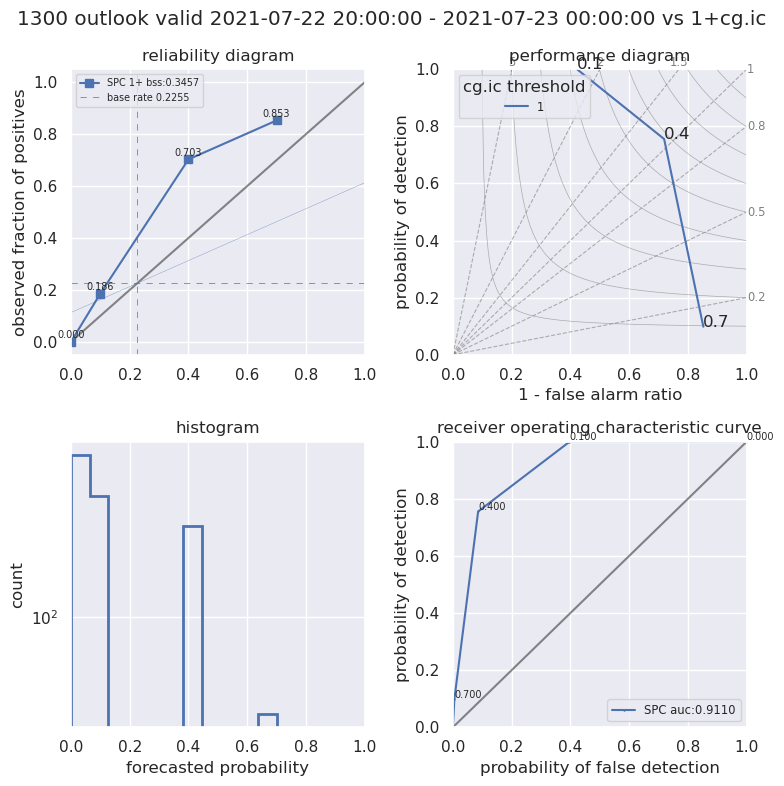

In [32]:
fig0 = stat_plots(
    obs,
    fcst,
    thresh=thresh,
    pthresh=pthresh,
    o_thresh=o_thresh,
    sep=0.01,
    n_bins=11,
    suptitle=f"{issue} outlook valid {valid_start} - {valid_end} vs {o_thresh}+{obsvar}",
)
ofile = tmpdir / "t.png"
fig0.savefig(ofile)
logging.warning(ofile)
fig0

## Verify dense neural network forecast

In [33]:
df = load_df(args)

# Put "valid_time", "y", and "x" in MultiIndex so we can group by them later.
# Otherwise they will be lost when you subset columns by feature_list.
# Used here and when calculating ensemble mean.
levels = ["initialization_time", "valid_time", "y", "x"]
df = df.set_index(levels)

# make sure df label is same as obs (got earlier)
assert all(
    df[f"{obsvar}_{rptdist}km_{twin}hr"].xs(
        valid_start + pd.Timedelta(hours=twin / 2), level="valid_time"
    )
    == obs.values
)

feature_list = get_features(args)

columns_before_filtering = df.columns
df = df[feature_list]
logging.info(f"dropped {set(columns_before_filtering) - set(df.columns)}")
logging.info(f"kept {len(df.columns)}/{len(columns_before_filtering)} features")

2023-10-31 09:36:39,930 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.2021072200-0000.par 0.1G mtime Tue Oct 31 09:35:20 2023 240 features 8 labels and 4 index_cols & dropna.


In [34]:
obs.values

array([  0.,   0., 611., ...,   0.,   0.,   0.], dtype=float32)

In [35]:
index = pd.MultiIndex.from_product(
    [range(args.kfold), range(args.nfits)], names=["fold", "fit"]
)
with Pool(processes=index.size) as pool:
    result = pool.starmap(predct, zip(index, repeat(args), repeat(df)))
y_preds = pd.concat(result, keys=index, names=index.names)

2023-10-31 09:36:45,754 (0, 0) nn/lightning/01+.4hr_0/1fold0
2023-10-31 09:36:45,791 (0, 1) nn/lightning/01+.4hr_1/1fold0
2023-10-31 09:36:45,822 (0, 2) nn/lightning/01+.4hr_2/1fold0
2023-10-31 09:36:45,857 (0, 3) nn/lightning/01+.4hr_3/1fold0
2023-10-31 09:36:45,887 (0, 4) nn/lightning/01+.4hr_4/1fold0
2023-10-31 09:36:46.050267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 09:36:46.050265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other ope

2/2 [==============================] - 0s 6ms/step


In [36]:
# I may have overlapping valid_times from different init_times like fhr=1 from today and fhr=25 from previous day
# average probability over all nfits initialized at initialization_time and valid at valid_time
ensmean = y_preds.groupby(level=levels).mean()
assert (
    "fit" not in ensmean.index.names
), "fit should not be a MultiIndex level of ensmean, the average probability over nfits."

dnntimes = pd.date_range(
    start=valid_start + pd.Timedelta(hours=twin / 2),
    end=valid_end - pd.Timedelta(hours=twin / 2),
    freq=f"{twin}H",
)
ensmean = ensmean.loc[(slice(None), dnntimes, slice(None), slice(None))]
ensmean.groupby("valid_time").first().index

DatetimeIndex(['2021-07-22 22:00:00'], dtype='datetime64[ns]', name='valid_time', freq=None)

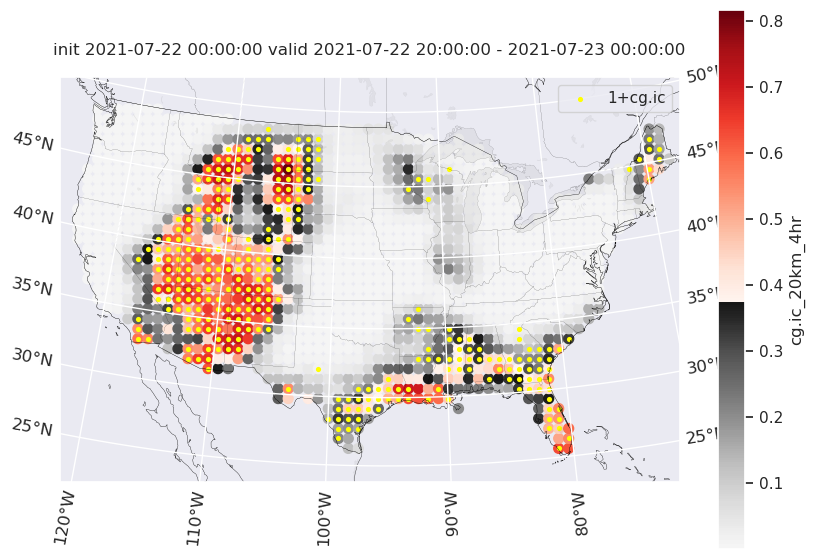

In [37]:
fig, ax = make_map(projection=map_crs)
f = f"{obsvar}_{rptdist}km_{twin}hr"


def getp(ensmean):
    # probability of no occurences during long time window = product of 1-p for all
    # smaller time window pieces

    prob_none = (1 - ensmean).groupby(["y", "x"]).prod()
    # 1 minus prob_none = prob of at least one occurence.
    p = 1 - prob_none
    # add to df so we can use df's lat and lon for coordinates.
    p["lon"] = df.groupby(["y", "x"]).mean(numeric_only=True).lon
    p["lat"] = df.groupby(["y", "x"]).mean(numeric_only=True).lat
    return p


p = getp(ensmean)
# don't pass zeros. spc has no zeros.
p[p[f] > 0].plot(
    ax=ax,
    cmap=cmap,
    c=f,
    kind="scatter",
    x="lon",
    y="lat",
    s=50,
    marker="o",
    transform=ccrs.PlateCarree(),
)
ax.set_title(f"init {args.idate} valid {valid_start} - {valid_end}")
ox = o.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    marker="o",
    markersize=3,
    color="yellow",
    label=f"{o_thresh}+{obsvar}",
    linewidths=2,
)
leg = ox.legend()
fig.savefig("t.png")
fig

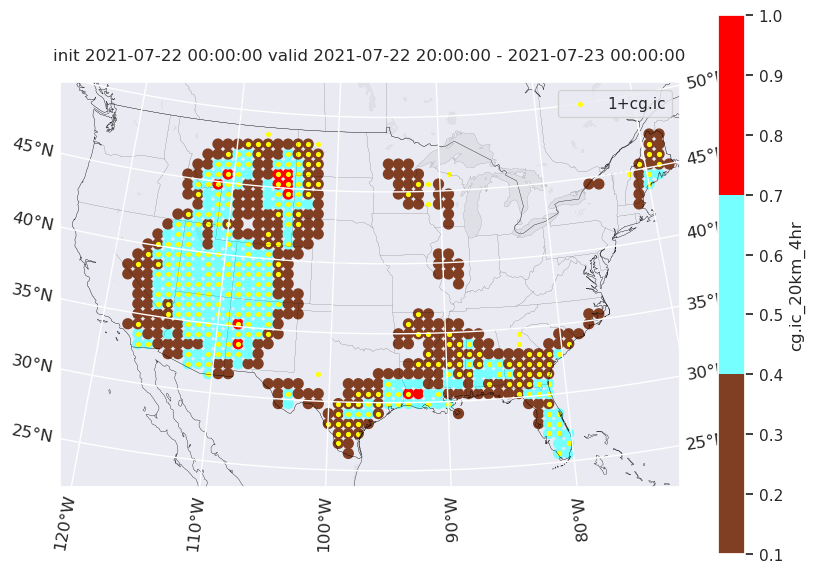

In [39]:
# 0-10-40-70
ensmean = ensmean.applymap(ztfs)

fig, ax = make_map(projection=map_crs)
p = getp(ensmean)
# don't pass zeros. spc has no zeros.
p[p[f] > 0].plot(
    ax=ax,
    cmap=enhtstm_cmap,
    c=f,
    norm=mpl.colors.Normalize(vmin=0.1, vmax=1),
    kind="scatter",
    x="lon",
    y="lat",
    s=50,
    marker="o",
    transform=ccrs.PlateCarree(),
)
ax.set_title(f"init {args.idate} valid {valid_start} - {valid_end}")
ox = o.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    marker="o",
    markersize=3,
    color="yellow",
    label=f"{o_thresh}+{obsvar}",
    linewidths=2,
)
leg = ox.legend()
fig.savefig("t.png")
fig

In [40]:
fcst = p[f]
pthresh = pd.Series(np.round(np.arange(0.2, 1, 0.2), 2), name=f"fcst\np thresh")

In [41]:
fig0 = stat_plots(
    obs,
    fcst,
    thresh=thresh,
    pthresh=pthresh,
    o_thresh=o_thresh,
    sep=0.15,
    n_bins=11,
    suptitle=(
        f"{issue} outlook valid {valid_start} - {valid_end}"
        f"\nDNN initialized {args.idate} vs {o_thresh}+{obsvar}"
    ),
    fig=fig0,
)

0.2794


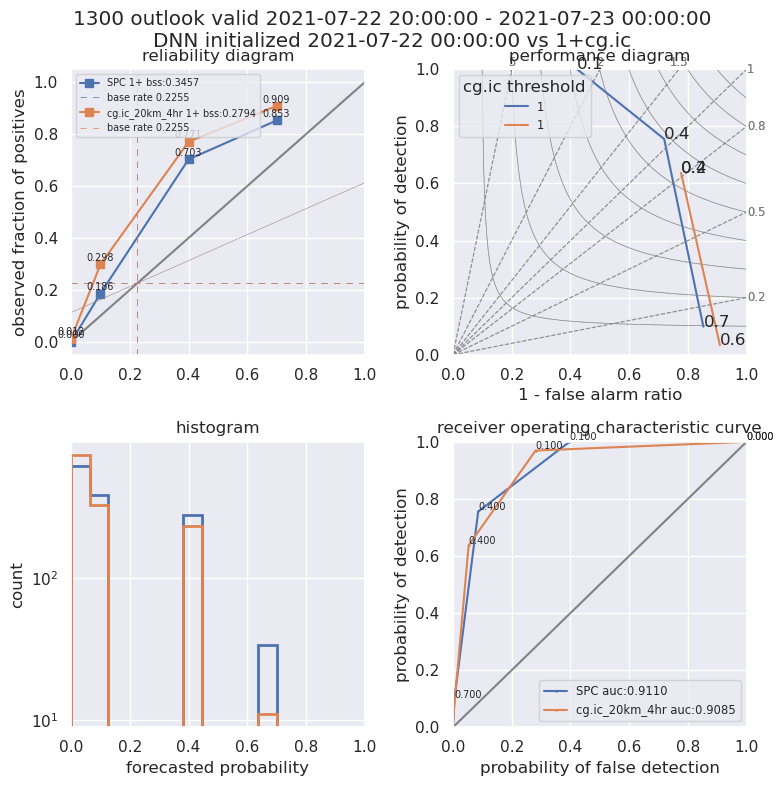

In [42]:
fig0.savefig(tmpdir / "t.png")
fig0

In [ ]:
from sklearn import metrics


def recall_score(obs, fcst):
    tp = (obs & fcst).sum()
    fn = (obs & ~fcst).sum()
    return tp / (tp + fn)
    return np.where(tp + fn == 0, 0, tp / (tp + fn))

In [ ]:
%timeit [recall_score(obs > t, fcst>=pt) for t in thresh.values for pt in pthresh.values]

In [ ]:
%timeit [metrics.recall_score(obs > t, fcst>=pt, zero_division=0) for t in thresh for pt in pthresh]

In [ ]:
assert obs.shape == fcst.shape